In [1]:
import pymysql
import pymysql.cursors
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [106]:
#connect my database

In [107]:
mydb = pymysql.connect(
    host='127.0.0.1',
    port=3306,
    user='root',
    passwd='',
    db='action'
    )

In [108]:
#merge table information

In [ ]:
cursor=mydb.cursor()
all_info_table_train='CREATE TABLE all_info_table_train2 AS\
                SELECT P.cate,A.user_id,A.sku_id,A.action_time,P.brand,P.shop_id,A.type,U.sex,U.age,U.user_lv_cd,U.city_level\
                FROM action AS A\
                JOIN product AS P ON P.sku_id=A.sku_id\
                JOIN user AS U ON U.user_id=A.user_id\
                WHERE A.type=2 AND A.sku_id IN (152092,37284,107331,19643,232801,58826,258625,44024,224207,141479) AND A.action_time BETWEEN "2018-02-05 00:00:00" AND "2018-04-09 00:00:00"'
cursor.execute(all_info_table_train)
myresult_train=cursor.fetchall()

In [51]:
cursor2=mydb.cursor()
all_info_table_test='CREATE TABLE all_info_table_test2 AS\
                SELECT P.cate,A.user_id,A.sku_id,A.action_time,P.brand,P.shop_id,A.type,U.sex,U.age,U.user_lv_cd,U.city_level\
                FROM action AS A\
                JOIN product AS P ON P.sku_id=A.sku_id\
                JOIN user AS U ON U.user_id=A.user_id\
                WHERE A.type=2 AND A.sku_id IN (152092,37284,107331,19643,232801,58826,258625,44024,224207,141479) AND A.action_time BETWEEN "2018-04-09 00:00:00" AND "2018-04-16 00:00:00"'
cursor2.execute(all_info_table_test)
myresult_test=cursor.fetchall()

In [52]:
cursor.close()

In [53]:
top10_all_info_table_train='SELECT *\
                            FROM all_info_table_train2\
                            limit 10'
sql_top_10_all_info_table_train=pd.read_sql_query(top10_all_info_table_train,mydb)
print(sql_top_10_all_info_table_train)

   cate  user_id  sku_id            action_time  brand  shop_id  type  sex  \
0    69   746638  152092  2018-02-05 12:06:13.0   5277     4005     2        
1    55   292617  107331  2018-02-23 15:45:43.0   2777     1634     2  0.0   
2    55   205710  107331  2018-03-01 10:05:30.0   2777     1634     2  0.0   
3    51   278949   44024  2018-02-22 00:03:26.0   8430      291     2  0.0   
4    27   983259  232801  2018-03-03 11:29:16.0   7132    10262     2  0.0   
5    55   126485  107331  2018-03-03 08:58:40.0   2777     1634     2  0.0   
6    27  1299620  232801  2018-02-18 23:38:23.0   7132    10262     2  1.0   
7     7   169415  258625  2018-02-06 08:59:26.0   7163      405     2  0.0   
8    34   437034   58826  2018-02-26 23:03:38.0   2777     6302     2  1.0   
9    55  1037635  107331  2018-02-17 17:08:55.0   2777     1634     2  0.0   

   age  user_lv_cd city_level  
0                7             
1  5.0           7        1.0  
2  5.0           1        5.0  
3  6.0       

In [264]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score as AUC
from sklearn.metrics import mean_absolute_error
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from scipy import stats
from copy import deepcopy
import csv
import os

In [265]:
test_df=pd.read_csv('/Users/charles/Desktop/consumer/all_info_table_test2.csv')
train_df=pd.read_csv('/Users/charles/Desktop/consumer/all_info_table_train2.csv')

In [266]:
test_df.head(5)

,cate,user_id,sku_id,action_time,brand,shop_id,type,sex,age,user_lv_cd,city_level
0,7,251406,224207,2018-04-12 00:00:36.0,7163,7114,2,0.0,6.0,7,1.0
1,55,1220272,107331,2018-04-10 21:09:47.0,2777,1634,2,0.0,5.0,7,1.0
2,69,1322926,152092,2018-04-12 11:10:41.0,5277,4005,2,0.0,6.0,7,1.0
3,34,575473,141479,2018-04-14 11:17:30.0,2484,3230,2,0.0,5.0,5,1.0
4,34,873211,58826,2018-04-11 15:57:21.0,2777,6302,2,1.0,6.0,1,5.0


In [267]:
test_df.shape

(4837, 11)

In [268]:
train_df.head(5)

,cate,user_id,sku_id,action_time,brand,shop_id,type,sex,age,user_lv_cd,city_level
0,69,746638,152092,2018-02-05 12:06:13.0,5277,4005,2,NaN,NaN,7,NaN
1,55,292617,107331,2018-02-23 15:45:43.0,2777,1634,2,0.0,5.0,7,1.0
2,55,205710,107331,2018-03-01 10:05:30.0,2777,1634,2,0.0,5.0,1,5.0
3,51,278949,44024,2018-02-22 00:03:26.0,8430,291,2,0.0,6.0,5,4.0
4,27,983259,232801,2018-03-03 11:29:16.0,7132,10262,2,0.0,6.0,1,4.0


In [269]:
train_df.shape

(46790, 11)

In [270]:
#find null value

In [271]:
pd.isnull(train_df).values.any()

True

In [272]:
#there is existing null vaule in train dataset

In [273]:
#clean null values

In [274]:
pd.isnull(train_df['cate']).values.any()

False

In [275]:
pd.isnull(train_df['user_id']).values.any()

False

In [276]:
pd.isnull(train_df['sku_id']).values.any()

False

In [277]:
pd.isnull(train_df['brand']).values.any()

False

In [278]:
pd.isnull(train_df['shop_id']).values.any()

False

In [279]:
pd.isnull(train_df['sex']).values.any()

True

Text(0, 0.5, 'count')

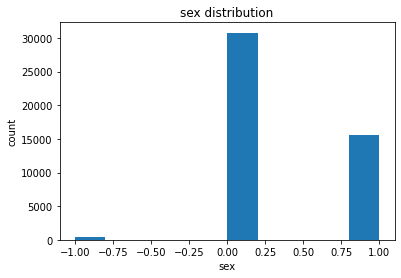

In [280]:
train_df['sex'].plot(kind='hist')
plt.title('sex distribution')
plt.xlabel('sex')
plt.ylabel('count')

In [281]:
pd.isnull(train_df['sex']).value_counts()

False    46755
True        35
Name: sex, dtype: int64

In [282]:
#the number is small, we delete them directly

In [283]:
train_df.dropna(subset=['sex'],how='any',inplace=True)

In [284]:
pd.isnull(train_df['age']).value_counts()

False    46755
Name: age, dtype: int64

In [285]:
train_df.dropna(subset=['age'],how='any',inplace=True)

In [286]:
#drop the sex =-1 

In [287]:
train_df=train_df.drop(train_df[(train_df['sex']==-1)].index)

In [288]:
test_df=test_df.drop(test_df[(test_df['sex']==-1)].index)

In [289]:
pd.isnull(train_df['user_lv_cd']).value_counts()

False    46369
Name: user_lv_cd, dtype: int64

In [290]:
pd.isnull(train_df['city_level']).value_counts()

False    46354
True        15
Name: city_level, dtype: int64

In [291]:
train_df.dropna(subset=['city_level'],how='any',inplace=True)

In [292]:
train_df.shape

(46354, 11)

In [293]:
pd.isnull(train_df).values.any()

False

Text(0, 0.5, 'sales')

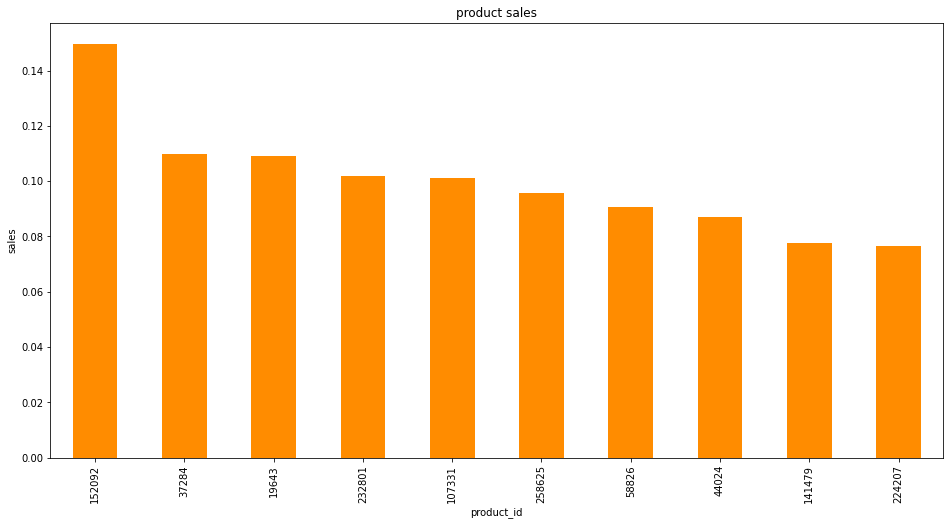

In [294]:
plt.figure(figsize=(16,8))
train_df['sku_id'].value_counts(normalize=True)[:10].plot(kind='bar',color='darkorange')
plt.title('product sales')
plt.xlabel('product_id')
plt.ylabel('sales')

In [295]:
type(train_df)

pandas.core.frame.DataFrame

In [296]:
train_df['action_time']=pd.to_datetime(train_df['action_time']).dt.strftime('%Y%m%d')

In [297]:
train_df.head(5)

,cate,user_id,sku_id,action_time,brand,shop_id,type,sex,age,user_lv_cd,city_level
1,55,292617,107331,20180223,2777,1634,2,0.0,5.0,7,1.0
2,55,205710,107331,20180301,2777,1634,2,0.0,5.0,1,5.0
3,51,278949,44024,20180222,8430,291,2,0.0,6.0,5,4.0
4,27,983259,232801,20180303,7132,10262,2,0.0,6.0,1,4.0
5,55,126485,107331,20180303,2777,1634,2,0.0,5.0,1,4.0


In [ ]:
'''
train_df[train_df['action_time']=[1 if j in range(20180205,20180212) else j for j in train_df['action_time']]]
train_df[train_df['action_time']=[2 if j in range(20180212,20180219) else j for j in train_df['action_time']]]
train_df[train_df['action_time']=[3 if j in range(20180219,20180226) else j for j in train_df['action_time']]]
train_df[train_df['action_time']=[4 if j in range(20180226,20180305) else j for j in train_df['action_time']]]
train_df[train_df['action_time']=[1 if j in range(20180305,20180312) else j for j in train_df['action_time']]]
train_df[train_df['action_time']=[2 if j in range(20180312,20180319) else j for j in train_df['action_time']]]
train_df[train_df['action_time']=[3 if j in range(20180319,20180326) else j for j in train_df['action_time']]]
train_df[train_df['action_time']=[4 if j in range(20180326,20180402) else j for j in train_df['action_time']]]
train_df[train_df['action_time']=[1 if j in range(20180402,20180409) else j for j in train_df['action_time']]]
'''

In [ ]:
'''train_df['week_level']=np.where(if train_df['action_time'] in range(20180205,20180212),1
                               else if train_df['action_time'] in range(20180212,20180219),2
                               else if train_df['action_time'] in range(20180219,20180226),3
                               else if train_df['action_time'] in range(20180226,20180305),4
                               else if train_df['action_time'] in range(20180305,20180312),1
                               else if train_df['action_time'] in range(20180312,20180319),2
                               else if train_df['action_time'] in range(20180319,20180326),3
                               else if train_df['action_time'] in range(20180326,20180402),4
                               else 1)
'''

In [ ]:
'''
train_df['week_level1']=np.where(train_df['action_time'] in range(20180205,20180212),1,0)
train_df['week_level2']=np.where(train_df['action_time'] in range(20180212,20180219),2,0)
train_df['week_level3']=np.where(train_df['action_time'] in range(20180219,20180226),3,0)
train_df['week_level4']=np.where(train_df['action_time'] in range(20180226,20180305),4,0)
train_df['week_level5']=np.where(train_df['action_time'] in range(20180305,20180312),1,0)
train_df['week_level6']=np.where(train_df['action_time'] in range(20180312,20180319),2,0)
train_df['week_level7']=np.where(train_df['action_time'] in range(20180319,20180326),3,0)
train_df['week_level8']=np.where(train_df['action_time'] in range(20180326,20180402),4,0)
train_df['week_level9']=np.where(train_df['action_time'] in range(20180402,20180409),1,0)
'''

In [298]:
train_df['action_time']=train_df['action_time'].astype('int')

In [299]:
print(train_df.dtypes)

cate             int64
user_id          int64
sku_id           int64
action_time      int64
brand            int64
shop_id          int64
type             int64
sex            float64
age            float64
user_lv_cd       int64
city_level     float64
dtype: object


In [300]:
train_df.loc[train_df.action_time>=20180402,'action_time']=9

In [301]:
train_df.loc[train_df.action_time>=20180326,'action_time']=8

In [302]:
train_df.loc[train_df.action_time>=20180319,'action_time']=7

In [303]:
train_df.loc[train_df.action_time>=20180312,'action_time']=6

In [304]:
train_df.loc[train_df.action_time>=20180305,'action_time']=5

In [305]:
train_df.loc[train_df.action_time>=20180226,'action_time']=4

In [306]:
train_df.loc[train_df.action_time>=20180219,'action_time']=3

In [307]:
train_df.loc[train_df.action_time>=20180212,'action_time']=2

In [308]:
train_df.loc[train_df.action_time>=20180205,'action_time']=1

In [309]:
train_df.head(5)

,cate,user_id,sku_id,action_time,brand,shop_id,type,sex,age,user_lv_cd,city_level
1,55,292617,107331,3,2777,1634,2,0.0,5.0,7,1.0
2,55,205710,107331,4,2777,1634,2,0.0,5.0,1,5.0
3,51,278949,44024,3,8430,291,2,0.0,6.0,5,4.0
4,27,983259,232801,4,7132,10262,2,0.0,6.0,1,4.0
5,55,126485,107331,4,2777,1634,2,0.0,5.0,1,4.0


<AxesSubplot:ylabel='Frequency'>

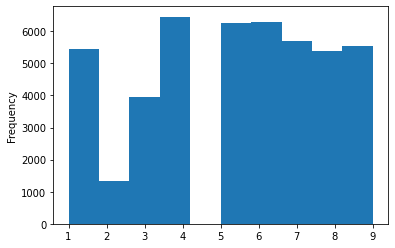

In [310]:
train_df['action_time'].plot(kind='hist')

In [311]:
from itertools import product

In [49]:
weeks=train_df['action_time'].unique()
cartesian=[]
for week in weeks:
    cate_sale_week=train_df.loc[train_df['action_time']==week,'cate'].unique()
    sku_id_week=train_df.loc[train_df['action_time']==week,'sku_id'].unique()
    brand_week=train_df.loc[train_df['action_time']==week,'brand'].unique()
    shop_id_week=train_df.loc[train_df['action_time']==week,'shop_id'].unique()
    sex_week=train_df.loc[train_df['action_time']==week,'sex'].unique()
    age_week=train_df.loc[train_df['action_time']==week,'age'].unique()
    user_level_week=train_df.loc[train_df['action_time']==week,'user_lv_cd'].unique()
    city_level_week=train_df.loc[train_df['action_time']==week,'city_level'].unique()
    cartesian.append(np.array(list(product(*[cate_sale_week,sku_id_week,brand_week,shop_id_week,sex_week,age_week,user_level_week,city_level_week,[week]])),dtype='int32'))
cartesian_df=pd.DataFrame(np.vstack(cartesian),columns=['cate','sku_id','brand','shop_id','sex','age','user_lv_cd','city_level','action_time'],dtype=np.int32)

In [49]:
cartesian_df

,cate,sku_id,brand,shop_id,sex,age,user_lv_cd,city_level,action_time
0,55,107331,2777,1634,0,5,7,1,3
1,55,107331,2777,1634,0,5,7,4,3
2,55,107331,2777,1634,0,5,7,3,3
3,55,107331,2777,1634,0,5,7,5,3
4,55,107331,2777,1634,0,5,7,6,3
...,...,...,...,...,...,...,...,...,...
15005755,7,258625,7163,405,1,3,3,1,9
15005756,7,258625,7163,405,1,3,3,5,9
15005757,7,258625,7163,405,1,3,3,3,9
15005758,7,258625,7163,405,1,3,3,6,9


In [312]:
#calculate the total sale of each product each day

In [313]:
train_df.insert(train_df.shape[1],'count',1)

In [314]:
train_df

,cate,user_id,sku_id,action_time,brand,shop_id,type,sex,age,user_lv_cd,city_level,count
1,55,292617,107331,3,2777,1634,2,0.0,5.0,7,1.0,1
2,55,205710,107331,4,2777,1634,2,0.0,5.0,1,5.0,1
3,51,278949,44024,3,8430,291,2,0.0,6.0,5,4.0,1
4,27,983259,232801,4,7132,10262,2,0.0,6.0,1,4.0,1
5,55,126485,107331,4,2777,1634,2,0.0,5.0,1,4.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
46785,69,1337253,152092,8,5277,4005,2,0.0,2.0,1,5.0,1
46786,69,1022656,152092,2,5277,4005,2,0.0,5.0,7,5.0,1
46787,51,933012,44024,7,8430,291,2,0.0,4.0,1,4.0,1
46788,69,462970,152092,7,5277,4005,2,0.0,5.0,1,4.0,1


In [315]:
x=train_df.groupby(['cate','sku_id','brand','shop_id','sex','age','user_lv_cd','city_level','action_time'])['count'].sum().rename('sales').reset_index()
x

,cate,sku_id,brand,shop_id,sex,age,user_lv_cd,city_level,action_time,sales
0,7,224207,7163,7114,0.0,1.0,1,1.0,5,1
1,7,224207,7163,7114,0.0,1.0,1,3.0,8,1
2,7,224207,7163,7114,0.0,1.0,1,4.0,7,2
3,7,224207,7163,7114,0.0,1.0,1,4.0,9,1
4,7,224207,7163,7114,0.0,1.0,1,5.0,7,1
...,...,...,...,...,...,...,...,...,...,...
9266,75,37284,9274,1122,1.0,6.0,7,5.0,6,1
9267,75,37284,9274,1122,1.0,6.0,7,5.0,7,2
9268,75,37284,9274,1122,1.0,6.0,7,5.0,8,4
9269,75,37284,9274,1122,1.0,6.0,7,5.0,9,1


In [316]:
#merge cartesian list and sale column
x.describe()

,cate,sku_id,brand,shop_id,sex,age,user_lv_cd,city_level,action_time,sales
count,9271.000000,9271.000000,9271.000000,9271.000000,9271.000000,9271.000000,9271.000000,9271.000000,9271.000000,9271.000000
mean,43.916514,113284.477403,5018.445799,3918.877791,0.444612,4.150361,4.621184,3.256067,5.234063,4.999892
std,19.960785,77435.201140,2805.219866,3011.084914,0.496950,1.713592,2.301999,1.450071,2.532211,7.285228
min,7.000000,19643.000000,1020.000000,291.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,34.000000,44024.000000,2777.000000,1122.000000,0.000000,2.000000,1.000000,2.000000,3.000000,1.000000
50%,34.000000,107331.000000,5277.000000,4005.000000,0.000000,5.000000,5.000000,3.000000,5.000000,3.000000
75%,55.000000,152092.000000,7163.000000,6302.000000,1.000000,6.000000,6.000000,4.000000,7.000000,6.000000
max,75.000000,258625.000000,9274.000000,10262.000000,1.000000,6.000000,7.000000,6.000000,9.000000,166.000000


In [317]:
train_new=x

In [318]:
#train_new.to_csv('/Users/charles/Desktop/consumer/train_new_10_clean.csv', index=False)

In [103]:
#train_new=pd.merge(cartesian_df,x,on=['cate','sku_id','brand','shop_id','sex','age','user_lv_cd','city_level','action_time'],how='left').fillna(0)

In [320]:
train_new

,cate,sku_id,brand,shop_id,sex,age,user_lv_cd,city_level,action_time,sales
0,7,224207,7163,7114,0.0,1.0,1,1.0,5,1
1,7,224207,7163,7114,0.0,1.0,1,3.0,8,1
2,7,224207,7163,7114,0.0,1.0,1,4.0,7,2
3,7,224207,7163,7114,0.0,1.0,1,4.0,9,1
4,7,224207,7163,7114,0.0,1.0,1,5.0,7,1
...,...,...,...,...,...,...,...,...,...,...
9266,75,37284,9274,1122,1.0,6.0,7,5.0,6,1
9267,75,37284,9274,1122,1.0,6.0,7,5.0,7,2
9268,75,37284,9274,1122,1.0,6.0,7,5.0,8,4
9269,75,37284,9274,1122,1.0,6.0,7,5.0,9,1


In [321]:
#data clean

In [322]:
def find_outlier(pro_id):
    x=train_new[train_new['sku_id']==product].sort_values(['sales'])
    print("product is ",pro_id,x)

In [323]:
product_num=train_df['sku_id'].unique()
for product in product_num:
    find_outlier(product)

product is  107331       cate  sku_id  brand  shop_id  sex  age  user_lv_cd  city_level  \
6502    55  107331   2777     1634  0.0  6.0           5         5.0   
6611    55  107331   2777     1634  1.0  1.0           7         4.0   
6610    55  107331   2777     1634  1.0  1.0           7         4.0   
6609    55  107331   2777     1634  1.0  1.0           7         3.0   
6608    55  107331   2777     1634  1.0  1.0           7         3.0   
...    ...     ...    ...      ...  ...  ...         ...         ...   
6303    55  107331   2777     1634  0.0  5.0           1         5.0   
6296    55  107331   2777     1634  0.0  5.0           1         4.0   
6330    55  107331   2777     1634  0.0  5.0           5         3.0   
6331    55  107331   2777     1634  0.0  5.0           5         3.0   
6295    55  107331   2777     1634  0.0  5.0           1         4.0   

      action_time  sales  
6502            2      1  
6611            7      1  
6610            6      1  
6609    

In [324]:
test_df.shape

(4810, 11)

In [325]:
test_df.dropna(how='any',inplace=True)

In [326]:
test_df.shape

(4805, 11)

In [327]:
test_df['action_time']=pd.to_datetime(test_df['action_time']).dt.strftime('%Y%m%d')
test_df['action_time']

0       20180412
1       20180410
2       20180412
3       20180414
4       20180411
          ...   
4832    20180413
4833    20180415
4834    20180411
4835    20180414
4836    20180414
Name: action_time, Length: 4805, dtype: object

In [328]:
test_df['action_time']=test_df['action_time'].astype('int')

In [329]:
test_df.loc[test_df.action_time>=20180409,'action_time']=10

In [330]:
test_df.head(10)

,cate,user_id,sku_id,action_time,brand,shop_id,type,sex,age,user_lv_cd,city_level
0,7,251406,224207,10,7163,7114,2,0.0,6.0,7,1.0
1,55,1220272,107331,10,2777,1634,2,0.0,5.0,7,1.0
2,69,1322926,152092,10,5277,4005,2,0.0,6.0,7,1.0
3,34,575473,141479,10,2484,3230,2,0.0,5.0,5,1.0
4,34,873211,58826,10,2777,6302,2,1.0,6.0,1,5.0
5,55,1601075,107331,10,2777,1634,2,0.0,1.0,1,5.0
6,55,128298,107331,10,2777,1634,2,0.0,4.0,5,4.0
7,7,90596,224207,10,7163,7114,2,0.0,1.0,7,4.0
8,75,1514993,37284,10,9274,1122,2,0.0,5.0,6,4.0
9,34,377247,58826,10,2777,6302,2,1.0,1.0,7,1.0


In [331]:
test_df.insert(test_df.shape[1],'count',1)

In [332]:
test_df

,cate,user_id,sku_id,action_time,brand,shop_id,type,sex,age,user_lv_cd,city_level,count
0,7,251406,224207,10,7163,7114,2,0.0,6.0,7,1.0,1
1,55,1220272,107331,10,2777,1634,2,0.0,5.0,7,1.0,1
2,69,1322926,152092,10,5277,4005,2,0.0,6.0,7,1.0,1
3,34,575473,141479,10,2484,3230,2,0.0,5.0,5,1.0,1
4,34,873211,58826,10,2777,6302,2,1.0,6.0,1,5.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
4832,27,1572777,232801,10,7132,10262,2,0.0,6.0,7,4.0,1
4833,27,1118236,232801,10,7132,10262,2,0.0,5.0,5,4.0,1
4834,27,591704,232801,10,7132,10262,2,0.0,2.0,1,5.0,1
4835,7,144497,224207,10,7163,7114,2,1.0,5.0,5,1.0,1


In [333]:
x=test_df.groupby(['cate','sku_id','brand','shop_id','sex','age','user_lv_cd','city_level','action_time'])['count'].sum().rename('sales').reset_index()
x

,cate,sku_id,brand,shop_id,sex,age,user_lv_cd,city_level,action_time,sales
0,7,224207,7163,7114,0.0,1.0,1,4.0,10,2
1,7,224207,7163,7114,0.0,1.0,5,1.0,10,4
2,7,224207,7163,7114,0.0,1.0,5,3.0,10,6
3,7,224207,7163,7114,0.0,1.0,5,5.0,10,1
4,7,224207,7163,7114,0.0,1.0,7,1.0,10,5
...,...,...,...,...,...,...,...,...,...,...
1041,75,37284,9274,1122,1.0,6.0,6,5.0,10,1
1042,75,37284,9274,1122,1.0,6.0,7,1.0,10,2
1043,75,37284,9274,1122,1.0,6.0,7,3.0,10,10
1044,75,37284,9274,1122,1.0,6.0,7,4.0,10,11


In [334]:
test_new=x
test_new

,cate,sku_id,brand,shop_id,sex,age,user_lv_cd,city_level,action_time,sales
0,7,224207,7163,7114,0.0,1.0,1,4.0,10,2
1,7,224207,7163,7114,0.0,1.0,5,1.0,10,4
2,7,224207,7163,7114,0.0,1.0,5,3.0,10,6
3,7,224207,7163,7114,0.0,1.0,5,5.0,10,1
4,7,224207,7163,7114,0.0,1.0,7,1.0,10,5
...,...,...,...,...,...,...,...,...,...,...
1041,75,37284,9274,1122,1.0,6.0,6,5.0,10,1
1042,75,37284,9274,1122,1.0,6.0,7,1.0,10,2
1043,75,37284,9274,1122,1.0,6.0,7,3.0,10,10
1044,75,37284,9274,1122,1.0,6.0,7,4.0,10,11


In [335]:
test_feature = test_new.drop(['sales'], axis=1)
test_value=test_new['sales'].values.tolist()
test_value

[2,
 4,
 6,
 1,
 5,
 27,
 21,
 7,
 5,
 4,
 3,
 4,
 20,
 24,
 17,
 12,
 1,
 2,
 1,
 1,
 4,
 2,
 2,
 6,
 8,
 7,
 23,
 29,
 22,
 19,
 4,
 1,
 1,
 6,
 1,
 9,
 17,
 9,
 38,
 1,
 70,
 66,
 21,
 4,
 1,
 1,
 1,
 1,
 1,
 1,
 5,
 1,
 1,
 1,
 1,
 1,
 9,
 5,
 4,
 1,
 9,
 6,
 7,
 1,
 7,
 1,
 2,
 4,
 1,
 1,
 2,
 7,
 18,
 2,
 1,
 1,
 1,
 4,
 4,
 1,
 1,
 4,
 4,
 3,
 1,
 2,
 1,
 2,
 1,
 1,
 1,
 8,
 5,
 14,
 4,
 1,
 1,
 1,
 2,
 2,
 6,
 11,
 19,
 4,
 1,
 2,
 1,
 1,
 2,
 2,
 2,
 1,
 2,
 1,
 1,
 1,
 2,
 1,
 2,
 1,
 2,
 3,
 2,
 2,
 4,
 1,
 2,
 2,
 1,
 1,
 2,
 1,
 3,
 4,
 7,
 1,
 1,
 2,
 4,
 3,
 1,
 8,
 7,
 2,
 1,
 9,
 11,
 20,
 10,
 4,
 15,
 15,
 3,
 11,
 9,
 13,
 5,
 4,
 12,
 10,
 3,
 6,
 4,
 4,
 4,
 3,
 4,
 4,
 3,
 8,
 6,
 6,
 3,
 1,
 7,
 7,
 3,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 3,
 1,
 2,
 1,
 1,
 2,
 1,
 3,
 6,
 3,
 2,
 2,
 1,
 6,
 6,
 1,
 4,
 1,
 10,
 8,
 3,
 2,
 5,
 5,
 5,
 3,
 3,
 11,
 7,
 1,
 4,
 1,
 1,
 4,
 4,
 6,
 3,
 2,
 4,
 3,
 1,
 4,
 4,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 3,
 1,
 1,
 3,
 1

In [336]:
test_feature2 = test_new.drop(['sales'], axis=1)
test_value2=test_new['sales'].values.tolist()
test_value2

[2,
 4,
 6,
 1,
 5,
 27,
 21,
 7,
 5,
 4,
 3,
 4,
 20,
 24,
 17,
 12,
 1,
 2,
 1,
 1,
 4,
 2,
 2,
 6,
 8,
 7,
 23,
 29,
 22,
 19,
 4,
 1,
 1,
 6,
 1,
 9,
 17,
 9,
 38,
 1,
 70,
 66,
 21,
 4,
 1,
 1,
 1,
 1,
 1,
 1,
 5,
 1,
 1,
 1,
 1,
 1,
 9,
 5,
 4,
 1,
 9,
 6,
 7,
 1,
 7,
 1,
 2,
 4,
 1,
 1,
 2,
 7,
 18,
 2,
 1,
 1,
 1,
 4,
 4,
 1,
 1,
 4,
 4,
 3,
 1,
 2,
 1,
 2,
 1,
 1,
 1,
 8,
 5,
 14,
 4,
 1,
 1,
 1,
 2,
 2,
 6,
 11,
 19,
 4,
 1,
 2,
 1,
 1,
 2,
 2,
 2,
 1,
 2,
 1,
 1,
 1,
 2,
 1,
 2,
 1,
 2,
 3,
 2,
 2,
 4,
 1,
 2,
 2,
 1,
 1,
 2,
 1,
 3,
 4,
 7,
 1,
 1,
 2,
 4,
 3,
 1,
 8,
 7,
 2,
 1,
 9,
 11,
 20,
 10,
 4,
 15,
 15,
 3,
 11,
 9,
 13,
 5,
 4,
 12,
 10,
 3,
 6,
 4,
 4,
 4,
 3,
 4,
 4,
 3,
 8,
 6,
 6,
 3,
 1,
 7,
 7,
 3,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 3,
 1,
 2,
 1,
 1,
 2,
 1,
 3,
 6,
 3,
 2,
 2,
 1,
 6,
 6,
 1,
 4,
 1,
 10,
 8,
 3,
 2,
 5,
 5,
 5,
 3,
 3,
 11,
 7,
 1,
 4,
 1,
 1,
 4,
 4,
 6,
 3,
 2,
 4,
 3,
 1,
 4,
 4,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 3,
 1,
 1,
 3,
 1

In [337]:
#cross validation

In [338]:
from sklearn.model_selection import train_test_split

In [339]:
from xgboost import XGBRegressor

In [340]:
from sklearn.metrics import r2_score

In [341]:
model = XGBRegressor(n_estimators=1500,
                     max_depth=10,
                     colsample_bytree=0.8, 
                     subsample=0.8, 
                     learning_rate = 0.2,
                     min_child_weight=1,
                     gamma=0,
                     reg_alpha=0,
                     reg_lambda=1
                    )

In [342]:
def cv_xgb():
    model.fit(x_train.values, y_train.values, 
              eval_metric="mae", 
              eval_set=[(x_train.values, y_train.values), (x_test.values, y_test.values)], 
              verbose=True, 
              early_stopping_rounds = 50)

In [343]:
mean_r2=[]
for i in range (1,11):
    x_train,x_test,y_train,y_test=train_test_split(train_new.drop(['sales'], axis=1),train_new['sales'],test_size=0.2)
    cv_xgb()
    y_pred=model.predict(test_feature2.values)
    print(y_pred)
    pred_value=list(y_pred)
    pred_values=[0 if j<0 else j for j in pred_value]
    #print(pred_values)
    r_square=r2_score(test_value2,pred_values)
    mean_r2.append(r_square)

[0]	validation_0-mae:3.76264	validation_1-mae:3.83930
[1]	validation_0-mae:3.26475	validation_1-mae:3.39161
[2]	validation_0-mae:2.87377	validation_1-mae:3.04186
[3]	validation_0-mae:2.51716	validation_1-mae:2.72085
[4]	validation_0-mae:2.36364	validation_1-mae:2.59146
[5]	validation_0-mae:2.13198	validation_1-mae:2.40973
[6]	validation_0-mae:2.08575	validation_1-mae:2.37008
[7]	validation_0-mae:2.05302	validation_1-mae:2.33370
[8]	validation_0-mae:1.91980	validation_1-mae:2.22703
[9]	validation_0-mae:1.80364	validation_1-mae:2.15600
[10]	validation_0-mae:1.73097	validation_1-mae:2.10670
[11]	validation_0-mae:1.64946	validation_1-mae:2.05205
[12]	validation_0-mae:1.59248	validation_1-mae:2.03097
[13]	validation_0-mae:1.55167	validation_1-mae:2.01548
[14]	validation_0-mae:1.50012	validation_1-mae:1.99356
[15]	validation_0-mae:1.46190	validation_1-mae:1.97652
[16]	validation_0-mae:1.40918	validation_1-mae:1.95242
[17]	validation_0-mae:1.38243	validation_1-mae:1.94394
[18]	validation_0-ma

In [344]:
print(mean_r2)
print(np.mean(mean_r2))

[0.6973926375646737, 0.6974235584266866, 0.719200070676123, 0.7013978066962936, 0.7051919022217636, 0.7164352335062341, 0.6974575885509122, 0.7297031037009272, 0.6851061400051645, 0.6967143982847044]
0.7046022439633483


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

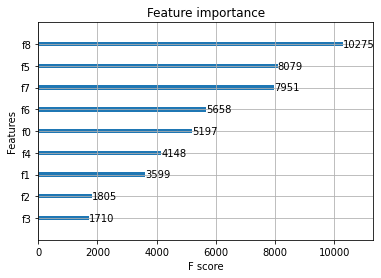

In [825]:
from xgboost import plot_importance
plot_importance(model)

<AxesSubplot:title={'center':'Feature Importance'}, xlabel='feature'>

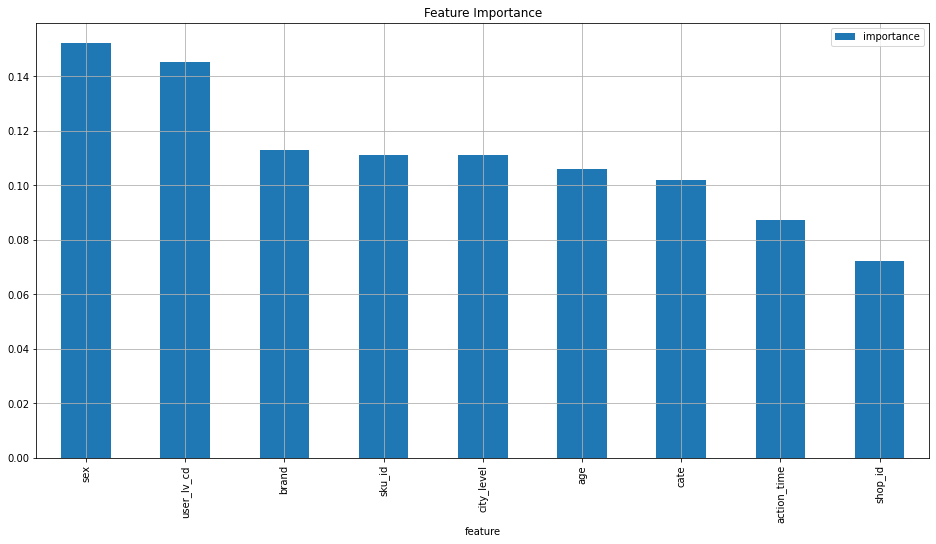

In [826]:
importances = pd.DataFrame({'feature':train_new.drop(['sales'], axis = 1).columns,'importance':np.round(model.feature_importances_,3)}) 
importances = importances.sort_values('importance',ascending=False).set_index('feature') 
importances = importances[importances['importance'] > 0.01]

importances.plot(kind='bar',
                 title = 'Feature Importance',
                 figsize = (16,8),
                 grid= 'both')

In [212]:
#drop the column city_level

In [345]:
train_new3=train_new.drop(['city_level'],axis=1)
test_new3=test_new.drop(['city_level'],axis=1)

In [346]:
train_new3=train_new3.groupby(['cate','sku_id','brand','shop_id','sex','age','user_lv_cd','action_time']).sum().reset_index()
test_new3=test_new3.groupby(['cate','sku_id','brand','shop_id','sex','age','user_lv_cd','action_time']).sum().reset_index()

In [347]:
test_feature3 = test_new3.drop(['sales'], axis=1)
test_value3=test_new3['sales'].values.tolist()
test_value3

[2,
 11,
 60,
 5,
 11,
 73,
 1,
 3,
 7,
 23,
 93,
 6,
 42,
 200,
 1,
 1,
 1,
 3,
 5,
 2,
 1,
 1,
 20,
 30,
 3,
 6,
 29,
 2,
 9,
 1,
 1,
 12,
 2,
 1,
 2,
 3,
 31,
 1,
 6,
 40,
 1,
 2,
 1,
 1,
 4,
 6,
 2,
 2,
 4,
 2,
 7,
 5,
 5,
 4,
 15,
 10,
 18,
 1,
 50,
 37,
 38,
 29,
 14,
 15,
 23,
 21,
 3,
 1,
 4,
 1,
 4,
 1,
 3,
 3,
 13,
 4,
 14,
 26,
 17,
 24,
 7,
 14,
 9,
 12,
 3,
 3,
 2,
 1,
 1,
 3,
 2,
 11,
 7,
 14,
 1,
 26,
 23,
 13,
 13,
 8,
 9,
 10,
 4,
 6,
 3,
 1,
 4,
 3,
 22,
 5,
 38,
 1,
 43,
 20,
 34,
 5,
 26,
 1,
 10,
 11,
 1,
 7,
 1,
 2,
 4,
 2,
 2,
 2,
 1,
 11,
 4,
 11,
 2,
 27,
 38,
 26,
 10,
 13,
 12,
 20,
 10,
 5,
 1,
 6,
 2,
 5,
 4,
 3,
 1,
 11,
 2,
 16,
 1,
 64,
 1,
 21,
 52,
 15,
 27,
 17,
 13,
 7,
 3,
 2,
 2,
 1,
 5,
 3,
 8,
 3,
 17,
 9,
 21,
 4,
 39,
 36,
 23,
 25,
 12,
 16,
 16,
 6,
 3,
 1,
 18,
 3,
 2,
 1,
 5,
 2,
 13,
 3,
 25,
 43,
 21,
 41,
 15,
 10,
 9,
 16,
 3,
 1,
 2,
 1,
 21,
 16,
 21,
 5,
 53,
 48,
 32,
 46,
 9,
 11,
 5,
 16,
 1,
 1,
 1,
 1,
 4,
 4,
 5,
 1,
 18,
 15,


In [348]:
model3 = XGBRegressor(n_estimators=1500,
                     max_depth=8,
                     colsample_bytree=0.8, 
                     subsample=0.9, 
                     learning_rate = 0.2,
                     min_child_weight=1,
                     gamma=0,
                     reg_alpha=0,
                     reg_lambda=1
                    )
def cv_xgb3():
    model3.fit(x_train.values, y_train.values, 
              eval_metric="mae", 
              eval_set=[(x_train.values, y_train.values), (x_test.values, y_test.values)], 
              verbose=True, 
              early_stopping_rounds = 50)

In [349]:
mean_r2=[]
for i in range (1,11):
    x_train,x_test,y_train,y_test=train_test_split(train_new3.drop(['sales'], axis=1),train_new3['sales'],test_size=0.2)
    cv_xgb3()
    y_pred=model3.predict(test_feature3.values)
    #print(y_pred)
    pred_value=list(y_pred)
    pred_values=[0 if j<0 else j for j in pred_value]
    #print(pred_values)
    r_square=r2_score(test_value3,pred_values)
    mean_r2.append(r_square)


[0]	validation_0-mae:12.83991	validation_1-mae:13.31937
[1]	validation_0-mae:10.97968	validation_1-mae:11.41447
[2]	validation_0-mae:9.27209	validation_1-mae:9.79074
[3]	validation_0-mae:8.21918	validation_1-mae:8.81893
[4]	validation_0-mae:7.55113	validation_1-mae:8.36524
[5]	validation_0-mae:7.13889	validation_1-mae:8.17613
[6]	validation_0-mae:6.90518	validation_1-mae:8.09742
[7]	validation_0-mae:6.82750	validation_1-mae:8.07226
[8]	validation_0-mae:6.15228	validation_1-mae:7.46969
[9]	validation_0-mae:5.49814	validation_1-mae:6.84729
[10]	validation_0-mae:5.05577	validation_1-mae:6.68897
[11]	validation_0-mae:4.97496	validation_1-mae:6.68445
[12]	validation_0-mae:4.53603	validation_1-mae:6.28677
[13]	validation_0-mae:4.20173	validation_1-mae:6.02331
[14]	validation_0-mae:3.99547	validation_1-mae:6.02134
[15]	validation_0-mae:3.94048	validation_1-mae:6.02211
[16]	validation_0-mae:3.77957	validation_1-mae:6.01396
[17]	validation_0-mae:3.74595	validation_1-mae:6.01861
[18]	validation_

In [350]:
print(mean_r2)
print(np.mean(mean_r2))

[0.8294531472415559, 0.7924876129068609, 0.7909339912770696, 0.8218754638222086, 0.8069882779983615, 0.7604604977083901, 0.7939736325870669, 0.8100374997476555, 0.7902199085752009, 0.8109418028475112]
0.800737183471188


In [ ]:
importances = pd.DataFrame({'feature':train_new3.drop(['sales'], axis = 1).columns,'importance':np.round(model.feature_importances_,3)}) 
importances = importances.sort_values('importance',ascending=False).set_index('feature') 
importances = importances[importances['importance'] > 0.01]

importances.plot(kind='bar',
                 title = 'Feature Importance',
                 figsize = (16,8),
                 grid= 'both')

In [351]:
pred_values==np.array(pred_values)
test_new3['Pred'] = pred_values
#test_new3.to_csv('/Users/charles/Desktop/consumer/Prediction_next_week_with_realvalue.csv', index=False)

In [352]:
test_new3

,cate,sku_id,brand,shop_id,sex,age,user_lv_cd,action_time,sales,Pred
0,7,224207,7163,7114,0.0,1.0,1,10,2,1.919117
1,7,224207,7163,7114,0.0,1.0,5,10,11,8.794277
2,7,224207,7163,7114,0.0,1.0,7,10,60,51.990097
3,7,224207,7163,7114,0.0,2.0,1,10,5,3.488974
4,7,224207,7163,7114,0.0,2.0,5,10,11,11.656371
...,...,...,...,...,...,...,...,...,...,...
344,75,37284,9274,1122,1.0,5.0,7,10,40,34.520149
345,75,37284,9274,1122,1.0,6.0,1,10,16,14.411004
346,75,37284,9274,1122,1.0,6.0,5,10,27,19.774124
347,75,37284,9274,1122,1.0,6.0,6,10,3,5.607285


In [262]:
test_newgroup3=test_new3.groupby(['sku_id']).sum().reset_index()

In [354]:
test_newgroup3.drop(['cate','brand','shop_id','sex','age','user_lv_cd','action_time'], axis=1)


,sku_id,sales,Pred
0,19643,385,479.571816
1,37284,697,648.700022
2,44024,371,682.598916
3,58826,479,393.224154
4,107331,372,395.833686
5,141479,485,445.633247
6,152092,785,728.451363
7,224207,640,609.957125
8,232801,465,763.010205
9,258625,126,186.241563


In [230]:
def find_outlier(pro_id):
    x=train_new3[train_new3['sku_id']==product].sort_values(['sales'])
    print("product is ",pro_id,x)
product_num=train_df['sku_id'].unique()
for product in product_num:
    find_outlier(product)

product is  107331       cate  sku_id  brand  shop_id  sex  age  user_lv_cd  action_time  sales
2206    55  107331   2777     1634  1.0  4.0           7            3      1
2138    55  107331   2777     1634  1.0  1.0           6            2      1
2158    55  107331   2777     1634  1.0  2.0           5            4      1
2100    55  107331   2777     1634  0.0  6.0           3            5      1
2099    55  107331   2777     1634  0.0  6.0           3            4      1
...    ...     ...    ...      ...  ...  ...         ...          ...    ...
2066    55  107331   2777     1634  0.0  5.0           5            4     81
2067    55  107331   2777     1634  0.0  5.0           5            5     84
2056    55  107331   2777     1634  0.0  5.0           1            6     87
2054    55  107331   2777     1634  0.0  5.0           1            4     91
2055    55  107331   2777     1634  0.0  5.0           1            5    104

[339 rows x 9 columns]
product is  44024       cate  sku

In [ ]:
#clean the train_new again

In [232]:
train_new3=train_new3.drop(train_new3[(train_new3['sku_id']==258625)&(train_new3['sales']==488)].index)
train_new3=train_new3.drop(train_new3[(train_new3['sku_id']==258625)&(train_new3['sales']==329)].index)
train_new3=train_new3.drop(train_new3[(train_new3['sku_id']==258625)&(train_new3['sales']==305)].index)
train_new3=train_new3.drop(train_new3[(train_new3['sku_id']==19643)&(train_new3['sales']==117)].index)
train_new3=train_new3.drop(train_new3[(train_new3['sku_id']==19643)&(train_new3['sales']==109)].index)

In [233]:
#train the model3 again

In [240]:
mean_r2=[]
for i in range (1,11):
    x_train,x_test,y_train,y_test=train_test_split(train_new3.drop(['sales'], axis=1),train_new3['sales'],test_size=0.2)
    cv_xgb3()
    y_pred=model3.predict(test_feature3.values)
    #print(y_pred)
    pred_value=list(y_pred)
    pred_values=[0 if j<0 else j for j in pred_value]
    #print(pred_values)
    r_square=r2_score(test_value3,pred_values)
    mean_r2.append(r_square)

[0]	validation_0-mae:12.53155	validation_1-mae:12.28453
[1]	validation_0-mae:10.63249	validation_1-mae:10.48751
[2]	validation_0-mae:8.99745	validation_1-mae:8.93159
[3]	validation_0-mae:7.77300	validation_1-mae:7.85194
[4]	validation_0-mae:7.01369	validation_1-mae:7.25865
[5]	validation_0-mae:6.53592	validation_1-mae:6.98009
[6]	validation_0-mae:6.10885	validation_1-mae:6.61556
[7]	validation_0-mae:5.97022	validation_1-mae:6.55468
[8]	validation_0-mae:5.55199	validation_1-mae:6.25860
[9]	validation_0-mae:5.35702	validation_1-mae:6.05575
[10]	validation_0-mae:5.07892	validation_1-mae:5.98173
[11]	validation_0-mae:4.84707	validation_1-mae:5.77799
[12]	validation_0-mae:4.70161	validation_1-mae:5.66036
[13]	validation_0-mae:4.36966	validation_1-mae:5.50169
[14]	validation_0-mae:4.19039	validation_1-mae:5.47009
[15]	validation_0-mae:4.07240	validation_1-mae:5.48974
[16]	validation_0-mae:4.06496	validation_1-mae:5.45960
[17]	validation_0-mae:3.87645	validation_1-mae:5.27506
[18]	validation_

In [241]:
print(mean_r2)
print(np.mean(mean_r2))

[0.780716843249691, 0.787953597143248, 0.7991648914282333, 0.7967171826300603, 0.8000463068114919, 0.8231186965136367, 0.752775374642541, 0.7947375377760217, 0.8140988472408544, 0.7895083524586806]
0.793883762989446


In [874]:
#the difference after data cleaning is small compared with before data cleaning
#we decide not to drop these data 

In [624]:
#drop the column user_lv_cd

In [839]:
train_new4=train_new.drop(['user_lv_cd'],axis=1)
test_new4=test_new.drop(['user_lv_cd'],axis=1)

In [840]:
train_new4=train_new4.groupby(['cate','sku_id','brand','shop_id','sex','age','city_level','action_time'])['sales'].sum().reset_index()
test_new4=test_new4.groupby(['cate','sku_id','brand','shop_id','sex','age','city_level','action_time'])['sales'].sum().reset_index()

In [841]:
test_feature4 = test_new4.drop(['sales'], axis=1)
test_value4=test_new4['sales'].values.tolist()
test_value4

[9,
 33,
 23,
 8,
 24,
 27,
 21,
 17,
 2,
 2,
 26,
 39,
 32,
 26,
 44,
 2,
 83,
 84,
 31,
 4,
 1,
 1,
 1,
 6,
 1,
 1,
 1,
 1,
 1,
 10,
 16,
 12,
 5,
 8,
 3,
 13,
 19,
 3,
 2,
 4,
 4,
 1,
 4,
 4,
 4,
 2,
 2,
 1,
 9,
 6,
 17,
 4,
 8,
 12,
 21,
 6,
 2,
 1,
 3,
 3,
 2,
 1,
 2,
 1,
 3,
 1,
 4,
 2,
 10,
 7,
 4,
 5,
 14,
 19,
 6,
 28,
 47,
 58,
 21,
 16,
 1,
 22,
 17,
 17,
 2,
 3,
 2,
 1,
 1,
 2,
 3,
 3,
 3,
 2,
 11,
 14,
 4,
 10,
 1,
 22,
 25,
 16,
 10,
 1,
 7,
 15,
 5,
 1,
 4,
 2,
 1,
 1,
 3,
 7,
 8,
 8,
 10,
 14,
 1,
 21,
 25,
 14,
 3,
 7,
 9,
 11,
 1,
 4,
 5,
 2,
 5,
 1,
 11,
 16,
 24,
 15,
 24,
 1,
 29,
 31,
 17,
 11,
 3,
 16,
 8,
 11,
 1,
 8,
 4,
 1,
 3,
 4,
 10,
 7,
 9,
 2,
 21,
 1,
 30,
 34,
 15,
 10,
 3,
 15,
 19,
 8,
 5,
 1,
 2,
 3,
 2,
 1,
 2,
 1,
 3,
 5,
 2,
 3,
 13,
 9,
 5,
 28,
 1,
 41,
 51,
 31,
 1,
 5,
 2,
 12,
 24,
 21,
 1,
 2,
 4,
 1,
 1,
 4,
 6,
 7,
 1,
 13,
 14,
 15,
 9,
 31,
 2,
 45,
 32,
 13,
 11,
 10,
 15,
 14,
 5,
 9,
 5,
 6,
 1,
 3,
 3,
 3,
 8,
 13,
 15,
 5,
 21,
 1,


In [842]:
model4 = XGBRegressor(n_estimators=1500,
                     max_depth=8,
                     colsample_bytree=0.8, 
                     subsample=0.9, 
                     learning_rate = 0.4,
                     min_child_weight=1,
                     gamma=0,
                     reg_alpha=0,
                     reg_lambda=1
                    )
def cv_xgb4():
    model4.fit(x_train.values, y_train.values, 
              eval_metric="mae", 
              eval_set=[(x_train.values, y_train.values), (x_test.values, y_test.values)], 
              verbose=True, 
              early_stopping_rounds = 50)

In [843]:
mean_r2=[]
for i in range (1,11):
    x_train,x_test,y_train,y_test=train_test_split(train_new4.drop(['sales'], axis=1),train_new4['sales'],test_size=0.2)
    cv_xgb4()
    y_pred=model4.predict(test_feature4.values)
    #print(y_pred)
    pred_value=list(y_pred)
    pred_values=[0 if j<0 else j for j in pred_value]
    #print(pred_values)
    r_square=r2_score(test_value4,pred_values)
    mean_r2.append(r_square)

[0]	validation_0-mae:9.92671	validation_1-mae:10.35755
[1]	validation_0-mae:7.55391	validation_1-mae:8.25529
[2]	validation_0-mae:5.53292	validation_1-mae:6.21111
[3]	validation_0-mae:4.99523	validation_1-mae:5.71932
[4]	validation_0-mae:4.11805	validation_1-mae:4.94785
[5]	validation_0-mae:4.08957	validation_1-mae:4.91991
[6]	validation_0-mae:3.68125	validation_1-mae:4.70580
[7]	validation_0-mae:3.60788	validation_1-mae:4.69111
[8]	validation_0-mae:3.45188	validation_1-mae:4.61200
[9]	validation_0-mae:3.15125	validation_1-mae:4.43682
[10]	validation_0-mae:2.96218	validation_1-mae:4.30012
[11]	validation_0-mae:2.88193	validation_1-mae:4.24252
[12]	validation_0-mae:2.78079	validation_1-mae:4.18313
[13]	validation_0-mae:2.74852	validation_1-mae:4.18115
[14]	validation_0-mae:2.73253	validation_1-mae:4.16546
[15]	validation_0-mae:2.71403	validation_1-mae:4.14871
[16]	validation_0-mae:2.67982	validation_1-mae:4.14959
[17]	validation_0-mae:2.58742	validation_1-mae:4.08706
[18]	validation_0-m

In [844]:
print(mean_r2)
print(np.mean(mean_r2))

[0.7344789873647486, 0.6865096778503625, 0.7629879960135205, 0.7317580758100983, 0.7307307252855433, 0.7551829021798374, 0.7690846158183381, 0.7117875959346189, 0.6753960611350343, 0.7216578619730462]
0.7279574499365149


<AxesSubplot:title={'center':'Feature Importance'}, xlabel='feature'>

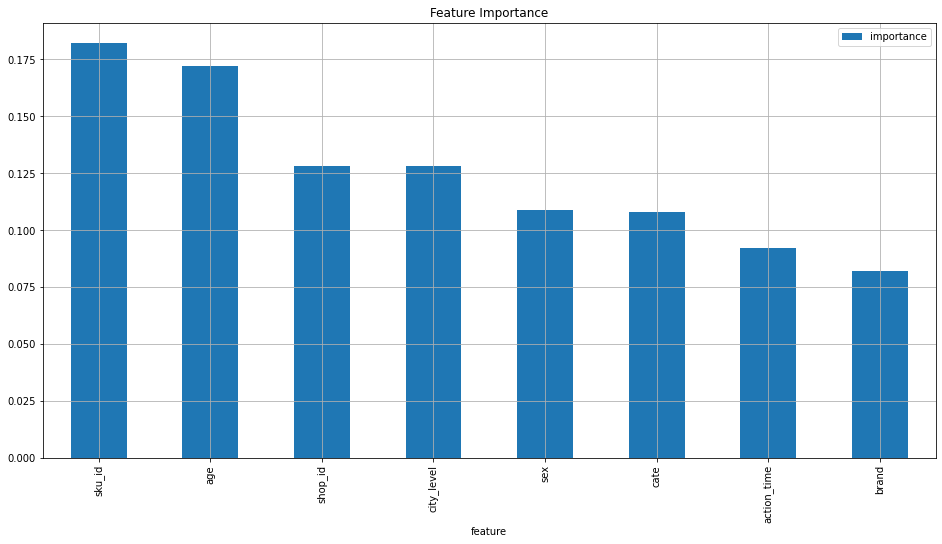

In [632]:
importances = pd.DataFrame({'feature':train_new4.drop(['sales'], axis = 1).columns,'importance':np.round(model.feature_importances_,3)}) 
importances = importances.sort_values('importance',ascending=False).set_index('feature') 
importances = importances[importances['importance'] > 0.01]

importances.plot(kind='bar',
                 title = 'Feature Importance',
                 figsize = (16,8),
                 grid= 'both')

In [845]:
pred_values==np.array(pred_values)
test_new4['Pred'] = pred_values

In [851]:
test_newgroup4=test_new4.groupby(['sku_id']).sum().reset_index()
test_newgroup4

,sku_id,cate,brand,shop_id,sex,age,city_level,action_time,sales,Pred
0,19643,1326,39780,169611,19.0,159.0,123.0,390,385,467.722363
1,37284,3300,408056,49368,22.0,170.0,142.0,440,697,649.725842
2,44024,1836,303480,10476,18.0,155.0,122.0,360,371,812.388351
3,58826,1564,127742,289892,26.0,171.0,150.0,460,479,408.524753
4,107331,2200,111080,65360,18.0,158.0,123.0,400,372,368.101098
5,141479,1530,111780,145350,23.0,167.0,148.0,450,485,449.282684
6,152092,3105,237465,180225,18.0,172.0,151.0,450,785,788.043867
7,224207,266,272194,270332,18.0,147.0,125.0,380,640,608.286651
8,232801,1161,306676,441266,23.0,160.0,141.0,430,465,808.256776
9,258625,182,186238,10530,8.0,102.0,81.0,260,126,196.424888


In [633]:
#drop the column age

In [634]:
train_new5=train_new.drop(['age'],axis=1)
test_new5=test_new.drop(['age'],axis=1)

In [635]:
train_new5=train_new5.groupby(['cate','sku_id','brand','shop_id','sex','user_lv_cd','city_level','action_time'])['sales'].sum().reset_index()
test_new5=test_new5.groupby(['cate','sku_id','brand','shop_id','sex','user_lv_cd','city_level','action_time'])['sales'].sum().reset_index()

In [636]:
test_feature5 = test_new5.drop(['sales'], axis=1)
test_value5=test_new5['sales'].values.tolist()
test_value5

[1,
 8,
 5,
 6,
 16,
 1,
 24,
 30,
 17,
 88,
 1,
 150,
 127,
 59,
 4,
 2,
 3,
 2,
 15,
 8,
 6,
 1,
 11,
 19,
 26,
 3,
 7,
 1,
 2,
 1,
 3,
 2,
 4,
 3,
 2,
 19,
 25,
 40,
 9,
 1,
 1,
 1,
 4,
 3,
 4,
 1,
 19,
 22,
 29,
 18,
 9,
 24,
 26,
 10,
 15,
 28,
 30,
 15,
 9,
 1,
 20,
 20,
 7,
 11,
 1,
 17,
 24,
 6,
 1,
 1,
 5,
 11,
 11,
 7,
 9,
 1,
 11,
 22,
 14,
 1,
 6,
 2,
 2,
 4,
 1,
 10,
 18,
 18,
 6,
 14,
 12,
 8,
 1,
 8,
 10,
 8,
 12,
 7,
 7,
 7,
 18,
 2,
 34,
 30,
 13,
 1,
 6,
 15,
 6,
 9,
 27,
 2,
 16,
 25,
 20,
 1,
 5,
 2,
 2,
 9,
 1,
 19,
 21,
 10,
 11,
 17,
 19,
 10,
 18,
 3,
 12,
 20,
 8,
 4,
 12,
 9,
 2,
 14,
 1,
 28,
 41,
 26,
 2,
 1,
 6,
 16,
 18,
 5,
 17,
 4,
 16,
 28,
 25,
 6,
 10,
 5,
 5,
 18,
 1,
 25,
 21,
 11,
 13,
 18,
 25,
 10,
 17,
 1,
 18,
 13,
 20,
 1,
 9,
 14,
 13,
 3,
 16,
 21,
 25,
 9,
 1,
 3,
 13,
 12,
 6,
 19,
 2,
 27,
 33,
 23,
 1,
 3,
 7,
 8,
 5,
 24,
 10,
 31,
 19,
 19,
 1,
 19,
 24,
 13,
 1,
 9,
 1,
 15,
 22,
 11,
 12,
 1,
 26,
 17,
 12,
 2,
 1,
 1,
 4,
 17,
 3,
 

In [710]:
model5 = XGBRegressor(n_estimators=1500,
                     max_depth=8,
                     colsample_bytree=0.8, 
                     subsample=0.8, 
                     learning_rate = 0.3,
                     min_child_weight=1,
                     gamma=0,
                     reg_alpha=0,
                     reg_lambda=1
                    )
def cv_xgb5():
    model5.fit(x_train.values, y_train.values, 
              eval_metric="mae", 
              eval_set=[(x_train.values, y_train.values), (x_test.values, y_test.values)], 
              verbose=True, 
              early_stopping_rounds = 50)

In [711]:
mean_r2=[]
for i in range (1,11):
    x_train,x_test,y_train,y_test=train_test_split(train_new5.drop(['sales'], axis=1),train_new5['sales'],test_size=0.2)
    cv_xgb5()
    y_pred=model5.predict(test_feature5.values)
    #print(y_pred)
    pred_value=list(y_pred)
    pred_values=[0 if j<0 else j for j in pred_value]
    #print(pred_values)
    r_square=r2_score(test_value5,pred_values)
    mean_r2.append(r_square)

[0]	validation_0-mae:11.52334	validation_1-mae:11.61292
[1]	validation_0-mae:10.03778	validation_1-mae:10.27557
[2]	validation_0-mae:8.07438	validation_1-mae:8.15429
[3]	validation_0-mae:6.71127	validation_1-mae:6.93462
[4]	validation_0-mae:6.28160	validation_1-mae:6.66547
[5]	validation_0-mae:5.58230	validation_1-mae:6.15074
[6]	validation_0-mae:5.42929	validation_1-mae:6.06562
[7]	validation_0-mae:5.16012	validation_1-mae:5.91669
[8]	validation_0-mae:4.96922	validation_1-mae:5.77524
[9]	validation_0-mae:4.52696	validation_1-mae:5.47972
[10]	validation_0-mae:4.30518	validation_1-mae:5.41311
[11]	validation_0-mae:4.10173	validation_1-mae:5.29220
[12]	validation_0-mae:3.91815	validation_1-mae:5.22811
[13]	validation_0-mae:3.82193	validation_1-mae:5.17916
[14]	validation_0-mae:3.73011	validation_1-mae:5.11314
[15]	validation_0-mae:3.68358	validation_1-mae:5.12818
[16]	validation_0-mae:3.66420	validation_1-mae:5.09834
[17]	validation_0-mae:3.51473	validation_1-mae:5.04971
[18]	validation_

In [712]:
print(mean_r2)
print(np.mean(mean_r2))

[0.7266815349603681, 0.7329015284997134, 0.7172175532308066, 0.719316494108047, 0.7110486339346791, 0.7265622855483629, 0.7267581915703167, 0.7116233440897868, 0.7134259267982894, 0.7163704154729307]
0.7201905908213302


<AxesSubplot:title={'center':'Feature Importance'}, xlabel='feature'>

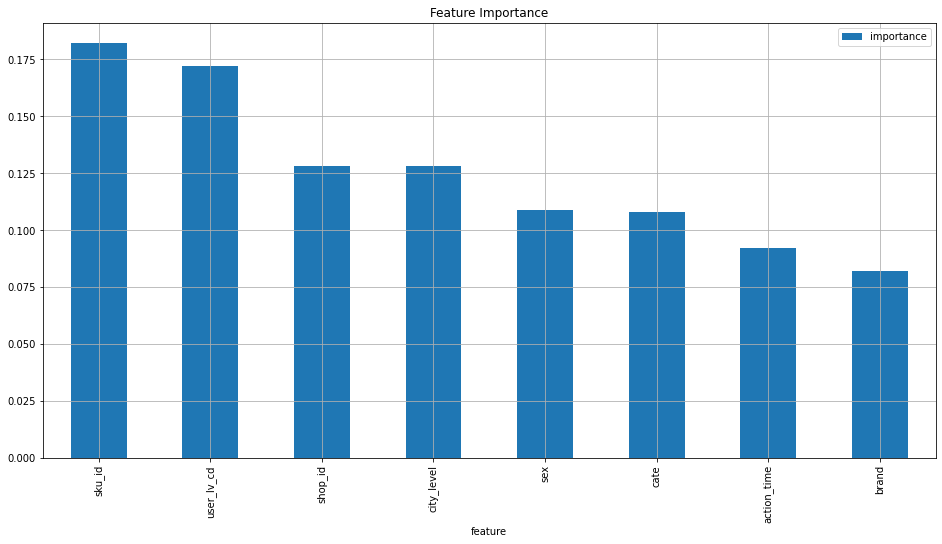

In [643]:
importances = pd.DataFrame({'feature':train_new5.drop(['sales'], axis = 1).columns,'importance':np.round(model.feature_importances_,3)}) 
importances = importances.sort_values('importance',ascending=False).set_index('feature') 
importances = importances[importances['importance'] > 0.01]

importances.plot(kind='bar',
                 title = 'Feature Importance',
                 figsize = (16,8),
                 grid= 'both')

In [654]:
#drop the column sex

In [655]:
train_new6=train_new.drop(['sex'],axis=1)
test_new6=test_new.drop(['sex'],axis=1)

In [656]:
train_new6=train_new6.groupby(['cate','sku_id','brand','shop_id','age','user_lv_cd','city_level','action_time'])['sales'].sum().reset_index()
test_new6=test_new6.groupby(['cate','sku_id','brand','shop_id','age','user_lv_cd','city_level','action_time'])['sales'].sum().reset_index()

In [657]:
test_feature6 = test_new6.drop(['sales'], axis=1)
test_value6=test_new6['sales'].values.tolist()
test_value6

[2,
 4,
 7,
 1,
 5,
 27,
 22,
 7,
 1,
 5,
 4,
 4,
 5,
 1,
 20,
 29,
 17,
 12,
 1,
 2,
 2,
 1,
 1,
 1,
 5,
 2,
 3,
 15,
 13,
 11,
 1,
 32,
 35,
 29,
 20,
 7,
 1,
 6,
 1,
 1,
 6,
 1,
 13,
 18,
 10,
 40,
 1,
 77,
 84,
 23,
 4,
 1,
 1,
 1,
 4,
 4,
 1,
 2,
 4,
 6,
 3,
 1,
 2,
 1,
 3,
 2,
 1,
 1,
 10,
 5,
 16,
 4,
 1,
 1,
 1,
 2,
 2,
 8,
 12,
 21,
 5,
 2,
 1,
 1,
 1,
 2,
 1,
 1,
 3,
 3,
 1,
 2,
 1,
 1,
 3,
 5,
 2,
 1,
 6,
 1,
 1,
 1,
 2,
 2,
 3,
 1,
 2,
 1,
 4,
 7,
 13,
 4,
 1,
 4,
 6,
 3,
 2,
 14,
 13,
 3,
 1,
 13,
 1,
 21,
 28,
 13,
 6,
 20,
 20,
 8,
 14,
 12,
 24,
 12,
 5,
 16,
 11,
 4,
 10,
 8,
 6,
 4,
 7,
 5,
 8,
 4,
 6,
 1,
 8,
 10,
 10,
 3,
 1,
 8,
 8,
 4,
 1,
 7,
 1,
 1,
 1,
 3,
 1,
 1,
 3,
 1,
 2,
 2,
 3,
 1,
 1,
 4,
 7,
 14,
 8,
 4,
 2,
 4,
 2,
 10,
 15,
 13,
 14,
 1,
 1,
 12,
 1,
 17,
 26,
 13,
 5,
 18,
 10,
 10,
 14,
 1,
 8,
 16,
 8,
 7,
 7,
 4,
 5,
 2,
 13,
 7,
 7,
 1,
 2,
 7,
 4,
 5,
 1,
 6,
 1,
 1,
 3,
 10,
 1,
 1,
 3,
 2,
 4,
 3,
 2,
 1,
 1,
 1,
 1,
 1,
 3,
 3,
 2,
 2,
 1,
 1

In [713]:
model6 = XGBRegressor(n_estimators=1500,
                     max_depth=8,
                     colsample_bytree=0.8, 
                     subsample=0.8, 
                     learning_rate = 0.3,
                     min_child_weight=1,
                     gamma=0,
                     reg_alpha=0,
                     reg_lambda=1
                    )
def cv_xgb6():
    model6.fit(x_train.values, y_train.values, 
              eval_metric="mae", 
              eval_set=[(x_train.values, y_train.values), (x_test.values, y_test.values)], 
              verbose=True, 
              early_stopping_rounds = 50)

In [714]:
mean_r2=[]
for i in range (1,11):
    x_train,x_test,y_train,y_test=train_test_split(train_new6.drop(['sales'], axis=1),train_new6['sales'],test_size=0.2)
    cv_xgb6()
    y_pred=model6.predict(test_feature6.values)
    #print(y_pred)
    pred_value=list(y_pred)
    pred_values=[0 if j<0 else j for j in pred_value]
    #print(pred_values)
    r_square=r2_score(test_value6,pred_values)
    mean_r2.append(r_square)

[0]	validation_0-mae:6.03351	validation_1-mae:6.12515
[1]	validation_0-mae:5.44120	validation_1-mae:5.60670
[2]	validation_0-mae:5.26247	validation_1-mae:5.51282
[3]	validation_0-mae:4.20669	validation_1-mae:4.47650
[4]	validation_0-mae:3.69042	validation_1-mae:4.01266
[5]	validation_0-mae:3.39309	validation_1-mae:3.78927
[6]	validation_0-mae:3.27164	validation_1-mae:3.70220
[7]	validation_0-mae:2.94562	validation_1-mae:3.36830
[8]	validation_0-mae:2.74611	validation_1-mae:3.19514
[9]	validation_0-mae:2.68846	validation_1-mae:3.14413
[10]	validation_0-mae:2.56339	validation_1-mae:3.04698
[11]	validation_0-mae:2.50372	validation_1-mae:2.99907
[12]	validation_0-mae:2.42167	validation_1-mae:2.95578
[13]	validation_0-mae:2.32136	validation_1-mae:2.87035
[14]	validation_0-mae:2.28518	validation_1-mae:2.84467
[15]	validation_0-mae:2.26112	validation_1-mae:2.83459
[16]	validation_0-mae:2.23795	validation_1-mae:2.83792
[17]	validation_0-mae:2.15429	validation_1-mae:2.77597
[18]	validation_0-ma

In [715]:
print(mean_r2)
print(np.mean(mean_r2))

[0.7023817038392246, 0.7113051978290339, 0.7112939251100696, 0.7166968949469879, 0.7144682332927978, 0.7350390091055652, 0.726153554467622, 0.7112029548076197, 0.721035218508107, 0.6724096124615444]
0.7121986304368573


In [664]:
#drop the cplumn city_level and shop_id

In [665]:
train_new7=train_new.drop(['city_level','shop_id'],axis=1)
test_new7=test_new.drop(['city_level','shop_id'],axis=1)

In [666]:
train_new7=train_new7.groupby(['cate','sku_id','brand','sex','age','user_lv_cd','action_time'])['sales'].sum().reset_index()
test_new7=test_new7.groupby(['cate','sku_id','brand','sex','age','user_lv_cd','action_time'])['sales'].sum().reset_index()

In [667]:
test_feature7 = test_new7.drop(['sales'], axis=1)
test_value7=test_new7['sales'].values.tolist()
test_value7

[2,
 11,
 60,
 5,
 11,
 73,
 1,
 3,
 7,
 23,
 93,
 6,
 42,
 200,
 1,
 1,
 1,
 3,
 5,
 2,
 1,
 1,
 20,
 30,
 3,
 6,
 29,
 2,
 9,
 1,
 1,
 12,
 2,
 1,
 2,
 3,
 31,
 1,
 6,
 40,
 1,
 2,
 1,
 1,
 4,
 6,
 2,
 2,
 4,
 2,
 7,
 5,
 5,
 4,
 15,
 10,
 18,
 1,
 50,
 37,
 38,
 29,
 14,
 15,
 23,
 21,
 3,
 1,
 4,
 1,
 4,
 1,
 3,
 3,
 13,
 4,
 14,
 26,
 17,
 24,
 7,
 14,
 9,
 12,
 3,
 3,
 2,
 1,
 1,
 3,
 2,
 11,
 7,
 14,
 1,
 26,
 23,
 13,
 13,
 8,
 9,
 10,
 4,
 6,
 3,
 1,
 4,
 3,
 22,
 5,
 38,
 1,
 43,
 20,
 34,
 5,
 26,
 1,
 10,
 11,
 1,
 7,
 1,
 2,
 4,
 2,
 2,
 2,
 1,
 11,
 4,
 11,
 2,
 27,
 38,
 26,
 10,
 13,
 12,
 20,
 10,
 5,
 1,
 6,
 2,
 5,
 4,
 3,
 1,
 11,
 2,
 16,
 1,
 64,
 1,
 21,
 52,
 15,
 27,
 17,
 13,
 7,
 3,
 2,
 2,
 1,
 5,
 3,
 8,
 3,
 17,
 9,
 21,
 4,
 39,
 36,
 23,
 25,
 12,
 16,
 16,
 6,
 3,
 1,
 18,
 3,
 2,
 1,
 5,
 2,
 13,
 3,
 25,
 43,
 21,
 41,
 15,
 10,
 9,
 16,
 3,
 1,
 2,
 1,
 21,
 16,
 21,
 5,
 53,
 48,
 32,
 46,
 9,
 11,
 5,
 16,
 1,
 1,
 1,
 1,
 4,
 4,
 5,
 1,
 18,
 15,


In [716]:
model7 = XGBRegressor(n_estimators=1500,
                     max_depth=7,
                     colsample_bytree=0.7, 
                     subsample=0.9, 
                     learning_rate = 0.1,
                     min_child_weight=1,
                     gamma=0,
                     reg_alpha=0,
                     reg_lambda=1
                    )
def cv_xgb7():
    model7.fit(x_train.values, y_train.values, 
              eval_metric="mae", 
              eval_set=[(x_train.values, y_train.values), (x_test.values, y_test.values)], 
              verbose=True, 
              early_stopping_rounds = 50)

In [717]:
mean_r2=[]
for i in range (1,11):
    x_train,x_test,y_train,y_test=train_test_split(train_new7.drop(['sales'], axis=1),train_new7['sales'],test_size=0.2)
    cv_xgb7()
    y_pred=model7.predict(test_feature7.values)
    #print(y_pred)
    pred_value=list(y_pred)
    pred_values=[0 if j<0 else j for j in pred_value]
    #print(pred_values)
    r_square=r2_score(test_value7,pred_values)
    mean_r2.append(r_square)

[0]	validation_0-mae:13.91406	validation_1-mae:12.79136
[1]	validation_0-mae:13.00200	validation_1-mae:12.03114
[2]	validation_0-mae:12.01319	validation_1-mae:11.23266
[3]	validation_0-mae:11.56132	validation_1-mae:10.92967
[4]	validation_0-mae:10.84964	validation_1-mae:10.39009
[5]	validation_0-mae:10.63409	validation_1-mae:10.28717
[6]	validation_0-mae:10.09410	validation_1-mae:9.88137
[7]	validation_0-mae:9.61404	validation_1-mae:9.51248
[8]	validation_0-mae:8.98320	validation_1-mae:9.02320
[9]	validation_0-mae:8.50177	validation_1-mae:8.57709
[10]	validation_0-mae:8.08158	validation_1-mae:8.29465
[11]	validation_0-mae:7.96497	validation_1-mae:8.27710
[12]	validation_0-mae:7.68037	validation_1-mae:8.10950
[13]	validation_0-mae:7.27938	validation_1-mae:7.76895
[14]	validation_0-mae:7.24963	validation_1-mae:7.79618
[15]	validation_0-mae:7.09586	validation_1-mae:7.72208
[16]	validation_0-mae:7.08323	validation_1-mae:7.74998
[17]	validation_0-mae:6.97085	validation_1-mae:7.70298
[18]	va

In [718]:
print(mean_r2)
print(np.mean(mean_r2))

[0.7544311661159168, 0.8008713466621612, 0.8011134688429429, 0.7256345914110558, 0.7414819688978607, 0.7492720847439986, 0.7781980738107273, 0.7455858217985242, 0.7572360820621774, 0.7887063684932616]
0.7642530972838626


In [722]:
#drop the cplumn shop_id
train_new8=train_new.drop(['shop_id'],axis=1)
test_new8=test_new.drop(['shop_id'],axis=1)
train_new8=train_new8.groupby(['cate','sku_id','brand','sex','age','city_level','user_lv_cd','action_time'])['sales'].sum().reset_index()
test_new8=test_new8.groupby(['cate','sku_id','brand','sex','age','city_level','user_lv_cd','action_time'])['sales'].sum().reset_index()
test_feature8 = test_new8.drop(['sales'], axis=1)
test_value8=test_new8['sales'].values.tolist()
model8 = XGBRegressor(n_estimators=1500,
                     max_depth=7,
                     colsample_bytree=0.7, 
                     subsample=0.9, 
                     learning_rate = 0.1,
                     min_child_weight=1,
                     gamma=0,
                     reg_alpha=0,
                     reg_lambda=1
                    )
def cv_xgb8():
    model8.fit(x_train.values, y_train.values, 
              eval_metric="mae", 
              eval_set=[(x_train.values, y_train.values), (x_test.values, y_test.values)], 
              verbose=True, 
              early_stopping_rounds = 50)
mean_r2=[]
for i in range (1,11):
    x_train,x_test,y_train,y_test=train_test_split(train_new8.drop(['sales'], axis=1),train_new8['sales'],test_size=0.2)
    cv_xgb8()
    y_pred=model8.predict(test_feature8.values)
    #print(y_pred)
    pred_value=list(y_pred)
    pred_values=[0 if j<0 else j for j in pred_value]
    #print(pred_values)
    r_square=r2_score(test_value8,pred_values)
    mean_r2.append(r_square)

[0]	validation_0-mae:4.09234	validation_1-mae:4.07224
[1]	validation_0-mae:3.82820	validation_1-mae:3.80965
[2]	validation_0-mae:3.59374	validation_1-mae:3.58202
[3]	validation_0-mae:3.45865	validation_1-mae:3.45016
[4]	validation_0-mae:3.27903	validation_1-mae:3.27805
[5]	validation_0-mae:3.07631	validation_1-mae:3.09711
[6]	validation_0-mae:2.98430	validation_1-mae:3.02098
[7]	validation_0-mae:2.87764	validation_1-mae:2.92549
[8]	validation_0-mae:2.84855	validation_1-mae:2.90211
[9]	validation_0-mae:2.77237	validation_1-mae:2.83450
[10]	validation_0-mae:2.71981	validation_1-mae:2.79287
[11]	validation_0-mae:2.68024	validation_1-mae:2.76359
[12]	validation_0-mae:2.60871	validation_1-mae:2.70048
[13]	validation_0-mae:2.55992	validation_1-mae:2.66006
[14]	validation_0-mae:2.54584	validation_1-mae:2.65424
[15]	validation_0-mae:2.48666	validation_1-mae:2.59919
[16]	validation_0-mae:2.44450	validation_1-mae:2.55876
[17]	validation_0-mae:2.39745	validation_1-mae:2.51912
[18]	validation_0-ma

In [723]:
print(mean_r2)
print(np.mean(mean_r2))

[0.6973819404536874, 0.691626956244001, 0.6850456823163117, 0.6914411726832586, 0.6705649717840314, 0.6874866700154395, 0.6718048416387882, 0.6913204401243878, 0.7024438053087105, 0.6882372121990481]
0.6877353692767665


In [726]:
#drop the cplumn brand
train_new9=train_new.drop(['brand'],axis=1)
test_new9=test_new.drop(['brand'],axis=1)
train_new9=train_new9.groupby(['cate','sku_id','shop_id','sex','age','city_level','user_lv_cd','action_time'])['sales'].sum().reset_index()
test_new9=test_new9.groupby(['cate','sku_id','shop_id','sex','age','city_level','user_lv_cd','action_time'])['sales'].sum().reset_index()
test_feature9 = test_new9.drop(['sales'], axis=1)
test_value9=test_new9['sales'].values.tolist()
model9 = XGBRegressor(n_estimators=1500,
                     max_depth=7,
                     colsample_bytree=0.7, 
                     subsample=0.9, 
                     learning_rate = 0.1,
                     min_child_weight=1,
                     gamma=0,
                     reg_alpha=0,
                     reg_lambda=1
                    )
def cv_xgb9():
    model9.fit(x_train.values, y_train.values, 
              eval_metric="mae", 
              eval_set=[(x_train.values, y_train.values), (x_test.values, y_test.values)], 
              verbose=True, 
              early_stopping_rounds = 50)
mean_r2=[]
for i in range (1,11):
    x_train,x_test,y_train,y_test=train_test_split(train_new9.drop(['sales'], axis=1),train_new9['sales'],test_size=0.2)
    cv_xgb9()
    y_pred=model9.predict(test_feature9.values)
    #print(y_pred)
    pred_value=list(y_pred)
    pred_values=[0 if j<0 else j for j in pred_value]
    #print(pred_values)
    r_square=r2_score(test_value9,pred_values)
    mean_r2.append(r_square)

[0]	validation_0-mae:4.13521	validation_1-mae:3.89934
[1]	validation_0-mae:3.87425	validation_1-mae:3.65053
[2]	validation_0-mae:3.62466	validation_1-mae:3.42903
[3]	validation_0-mae:3.49063	validation_1-mae:3.30344
[4]	validation_0-mae:3.30956	validation_1-mae:3.13901
[5]	validation_0-mae:3.10641	validation_1-mae:2.96675
[6]	validation_0-mae:3.01415	validation_1-mae:2.88246
[7]	validation_0-mae:2.90331	validation_1-mae:2.79289
[8]	validation_0-mae:2.87649	validation_1-mae:2.76681
[9]	validation_0-mae:2.79354	validation_1-mae:2.70243
[10]	validation_0-mae:2.73498	validation_1-mae:2.65893
[11]	validation_0-mae:2.69555	validation_1-mae:2.63032
[12]	validation_0-mae:2.62329	validation_1-mae:2.57999
[13]	validation_0-mae:2.57217	validation_1-mae:2.54300
[14]	validation_0-mae:2.56004	validation_1-mae:2.53098
[15]	validation_0-mae:2.50021	validation_1-mae:2.48185
[16]	validation_0-mae:2.45557	validation_1-mae:2.46116
[17]	validation_0-mae:2.40445	validation_1-mae:2.41893
[18]	validation_0-ma

In [727]:
print(mean_r2)
print(np.mean(mean_r2))

[0.6966641380765223, 0.6873335164861323, 0.7179126177357702, 0.6708112595300402, 0.7085550186533416, 0.7027233106376705, 0.6924816955518703, 0.7042818086289764, 0.6832837187667995, 0.666379360034971]
0.6930426444102095


In [728]:
#drop the cplumn cate
train_new10=train_new.drop(['cate'],axis=1)
test_new10=test_new.drop(['cate'],axis=1)
train_new10=train_new10.groupby(['brand','sku_id','shop_id','sex','age','city_level','user_lv_cd','action_time'])['sales'].sum().reset_index()
test_new10=test_new10.groupby(['brand','sku_id','shop_id','sex','age','city_level','user_lv_cd','action_time'])['sales'].sum().reset_index()
test_feature10 = test_new10.drop(['sales'], axis=1)
test_value10=test_new10['sales'].values.tolist()
model10 = XGBRegressor(n_estimators=1500,
                     max_depth=10,
                     colsample_bytree=0.7, 
                     subsample=0.9, 
                     learning_rate = 0.1,
                     min_child_weight=1,
                     gamma=0,
                     reg_alpha=0,
                     reg_lambda=1
                    )
def cv_xgb10():
    model10.fit(x_train.values, y_train.values, 
              eval_metric="mae", 
              eval_set=[(x_train.values, y_train.values), (x_test.values, y_test.values)], 
              verbose=True, 
              early_stopping_rounds = 50)
mean_r2=[]
for i in range (1,11):
    x_train,x_test,y_train,y_test=train_test_split(train_new10.drop(['sales'], axis=1),train_new10['sales'],test_size=0.2)
    cv_xgb10()
    y_pred=model10.predict(test_feature10.values)
    #print(y_pred)
    pred_value=list(y_pred)
    pred_values=[0 if j<0 else j for j in pred_value]
    #print(pred_values)
    r_square=r2_score(test_value10,pred_values)
    mean_r2.append(r_square)

[0]	validation_0-mae:4.10639	validation_1-mae:4.03663
[1]	validation_0-mae:3.83932	validation_1-mae:3.77638
[2]	validation_0-mae:3.58927	validation_1-mae:3.55052
[3]	validation_0-mae:3.44104	validation_1-mae:3.42049
[4]	validation_0-mae:3.24715	validation_1-mae:3.25252
[5]	validation_0-mae:3.02376	validation_1-mae:3.04891
[6]	validation_0-mae:2.92058	validation_1-mae:2.95259
[7]	validation_0-mae:2.79910	validation_1-mae:2.85639
[8]	validation_0-mae:2.76732	validation_1-mae:2.83240
[9]	validation_0-mae:2.67253	validation_1-mae:2.75887
[10]	validation_0-mae:2.60692	validation_1-mae:2.71164
[11]	validation_0-mae:2.54482	validation_1-mae:2.68045
[12]	validation_0-mae:2.46040	validation_1-mae:2.61281
[13]	validation_0-mae:2.39884	validation_1-mae:2.56820
[14]	validation_0-mae:2.38166	validation_1-mae:2.56241
[15]	validation_0-mae:2.31318	validation_1-mae:2.50185
[16]	validation_0-mae:2.25843	validation_1-mae:2.46812
[17]	validation_0-mae:2.18269	validation_1-mae:2.40308
[18]	validation_0-ma

In [729]:
print(mean_r2)
print(np.mean(mean_r2))

[0.6833203244265177, 0.6832656283168748, 0.7045657048847862, 0.6865783985379628, 0.6741439126820177, 0.6806284011580427, 0.6569760741219544, 0.683656680108022, 0.7080639022761244, 0.7041535938251227]
0.6865352620337426


In [730]:
#drop the cplumn cate and city_level
train_new11=train_new.drop(['cate','city_level'],axis=1)
test_new11=test_new.drop(['cate','city_level'],axis=1)
train_new11=train_new11.groupby(['brand','sku_id','shop_id','sex','age','user_lv_cd','action_time'])['sales'].sum().reset_index()
test_new11=test_new11.groupby(['brand','sku_id','shop_id','sex','age','user_lv_cd','action_time'])['sales'].sum().reset_index()
test_feature11 = test_new11.drop(['sales'], axis=1)
test_value11=test_new11['sales'].values.tolist()
model11 = XGBRegressor(n_estimators=1500,
                     max_depth=10,
                     colsample_bytree=0.7, 
                     subsample=0.9, 
                     learning_rate = 0.1,
                     min_child_weight=1,
                     gamma=0,
                     reg_alpha=0,
                     reg_lambda=1
                    )
def cv_xgb11():
    model11.fit(x_train.values, y_train.values, 
              eval_metric="mae", 
              eval_set=[(x_train.values, y_train.values), (x_test.values, y_test.values)], 
              verbose=True, 
              early_stopping_rounds = 50)
mean_r2=[]
for i in range (1,11):
    x_train,x_test,y_train,y_test=train_test_split(train_new11.drop(['sales'], axis=1),train_new11['sales'],test_size=0.2)
    cv_xgb11()
    y_pred=model11.predict(test_feature11.values)
    #print(y_pred)
    pred_value=list(y_pred)
    pred_values=[0 if j<0 else j for j in pred_value]
    #print(pred_values)
    r_square=r2_score(test_value11,pred_values)
    mean_r2.append(r_square)

[0]	validation_0-mae:13.81712	validation_1-mae:13.40199
[1]	validation_0-mae:12.92894	validation_1-mae:12.62905
[2]	validation_0-mae:11.96166	validation_1-mae:11.73900
[3]	validation_0-mae:11.48725	validation_1-mae:11.35723
[4]	validation_0-mae:10.78996	validation_1-mae:10.73676
[5]	validation_0-mae:10.55926	validation_1-mae:10.58563
[6]	validation_0-mae:10.01983	validation_1-mae:10.12253
[7]	validation_0-mae:9.54485	validation_1-mae:9.74064
[8]	validation_0-mae:8.86964	validation_1-mae:9.15307
[9]	validation_0-mae:8.36705	validation_1-mae:8.67885
[10]	validation_0-mae:7.89521	validation_1-mae:8.32930
[11]	validation_0-mae:7.76516	validation_1-mae:8.26473
[12]	validation_0-mae:7.45895	validation_1-mae:8.08778
[13]	validation_0-mae:6.99820	validation_1-mae:7.72856
[14]	validation_0-mae:6.96278	validation_1-mae:7.73581
[15]	validation_0-mae:6.79760	validation_1-mae:7.61144
[16]	validation_0-mae:6.78123	validation_1-mae:7.62437
[17]	validation_0-mae:6.66003	validation_1-mae:7.53966
[18]	v

In [731]:
print(mean_r2)
print(np.mean(mean_r2))

[0.7756523940638558, 0.7822508023801131, 0.7483716254452788, 0.7658526704096756, 0.7704416918340625, 0.7550740289502944, 0.7967657622102905, 0.7835626723057539, 0.7785189496176085, 0.7823250107968964]
0.773881560801383
